#### Read in data

In [1]:
import numpy as np
import pandas as pd
df = pd.read_csv('msfa_data.csv')
df['obs_se'] = .05
df['group'] = np.arange(df.shape[0])
df.head()

,location_id,year_id,physicians,nurses,uhc,uhc_variance,obs_se,group
0,6,1990,8.498420,7.458451,0.533304,0.000051,0.05,0
1,6,1991,9.184645,7.949018,0.537839,0.000051,0.05,1
2,6,1992,9.858267,8.474302,0.542701,0.000051,0.05,2
3,6,1993,10.543810,9.034594,0.550867,0.000050,0.05,3
4,6,1994,11.254521,9.627584,0.560277,0.000047,0.05,4


#### Build inputs

In [2]:
from anml.parameter.parameter import Parameter, ParameterSet
from anml.parameter.prior import GaussianPrior, Prior
from anml.parameter.processors import process_all
from anml.parameter.spline_variable import Spline, SplineLinearConstr
from anml.parameter.variables import Intercept
from sfma.data import DataSpecs
from sfma.data import Data

In [3]:
data_spec = DataSpecs(col_obs='uhc', col_obs_se='obs_se')

increasing = SplineLinearConstr(order=1, y_bounds=[0.0, np.inf], grid_size=20)
concave = SplineLinearConstr(order=2, y_bounds=[-np.inf, 0.0], grid_size=20)                                                

spline = Spline(
    covariate='physicians',
    knots_type='domain', knots_num=4, 
    degree=3, r_linear=True, include_intercept=True, 
    derivative_constr=[increasing, concave],
)
spline.set_fe_prior(Prior(lower_bound=[0.0] * spline.num_fe, upper_bound=[1.0] * spline.num_fe))
param_set_marginal = ParameterSet([Parameter(param_name='beta', variables=[spline])])
process_all(param_set_marginal, df)


intercept = Intercept(add_re=True, col_group='group', re_prior=GaussianPrior(lower_bound=[0.0], upper_bound=[np.inf]))
param_set_v = ParameterSet([Parameter(param_name='v', variables=[intercept])])
process_all(param_set_v, df)

data = Data(data_spec)
data.process(df)

#### Build Models

In [4]:
from sfma.models.maximal import VModel, UModel
from sfma.models.marginal import SimpleBetaEtaModel

In [5]:
marginal_model = SimpleBetaEtaModel(param_set_marginal)
v_model = VModel(param_set_v) 

#### Solve

In [6]:
from anml.solvers.base import ClosedFormSolver, ScipyOpt, IPOPTSolver

In [7]:
marginal_solver = IPOPTSolver(marginal_model)
v_solver = ClosedFormSolver(v_model)

In [8]:
from sfma.solver import SimpleSolver

In [9]:
ss = SimpleSolver([marginal_solver, v_solver])

In [10]:
x_init = np.random.randn(marginal_solver.model.x_dim)
ss.fit(x_init, data)

/Users/jizez/miniconda3/envs/meowkit/lib/python3.7/site-packages/sfma-0.0.0-py3.7.egg/sfma/models/marginal.py:32: RuntimeWarning: divide by zero encountered in log
  return np.mean(r**2 / (2 * V) + 0.5 * np.log(V) - np.log(Phi))
/Users/jizez/.local/lib/python3.7/site-packages/numpy-1.17.2-py3.7-macosx-10.7-x86_64.egg/numpy/core/_methods.py:161: RuntimeWarning: invalid value encountered in cdouble_scalars
  ret = ret.dtype.type(ret / rcount)



#### Plot

In [11]:
import matplotlib.pyplot as plt

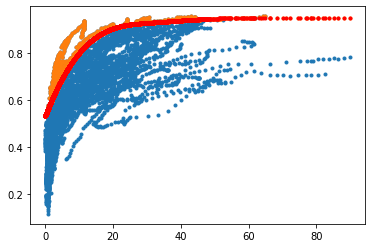

In [12]:
plt.plot(df['physicians'].to_numpy(), data.obs, '.', label='data')
plt.plot(df['physicians'].to_numpy(), data.obs + ss.x_opt[1], '.', label='data + v')
plt.plot(df['physicians'].to_numpy(), ss.predict(), '.r', label='x*beta')